# AnyoneAI - Project II

# Making Predictions with NBA data

In our first project, we learned how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using the Scikit Learn library

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## 1. Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

## EDA 
### Analyzing our data

In [3]:
# Data processing
#-----------------------
import pandas as pd
import numpy as np

#Visualization
#-----------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap

# Machine learning
#-----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, robust_scale
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as MAE,accuracy_score,precision_score,recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

# Miscellanoos
#-----------------------
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280,"23 years, 0 months, 0 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,"29 years, 1 months, 30 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,"25 years, 2 months, 1 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,"21 years, 8 months, 9 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,"37 years, 2 months, 0 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1626153,Delon Wright,Wizards,Guard,196,84,USA,1992-04-26,7,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,"30 years, 4 months, 24 days"
425,201152,Thaddeus Young,Raptors,Forward,203,107,USA,1988-06-21,15,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,"34 years, 2 months, 29 days"
426,1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,4,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,"24 years, 0 months, 0 days"
427,1630209,Omer Yurtseven,Heat,Center,211,125,Turkey,1998-06-19,1,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,"24 years, 3 months, 0 days"


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

In [3]:
stats_cols = ["PTS", "REB", "AST","STL","BLK","SEASON_EXP"]
data_stats = data.set_index('PERSON_ID')[stats_cols + ["POSITION","SALARY"]].copy()
data_stats

,PTS,REB,AST,STL,BLK,SEASON_EXP,POSITION,SALARY
PERSON_ID,,,,,,,,
1630173,7.2,5.1,0.8,0.4,0.5,2,Forward,2711280
203500,9.3,8.0,1.5,0.9,0.9,9,Center,17073171
1628389,13.5,8.3,3.5,1.0,0.9,5,Center,28103550
1630583,4.1,2.7,0.7,0.2,0.3,1,Forward,1994520
200746,19.1,8.1,1.9,0.7,1.1,16,Center,2641691
...,...,...,...,...,...,...,...,...
1626153,7.2,3.2,3.0,1.2,0.4,7,Guard,8526316
201152,12.8,5.8,1.8,1.4,0.4,15,Forward,14190000
1629027,25.3,3.9,9.1,0.9,0.2,4,Guard,8326471


In [4]:
## NaN Values Analysis
data_stats.isna().sum()

PTS           0
REB           0
AST           0
STL           0
BLK           0
SEASON_EXP    0
POSITION      0
SALARY        0
dtype: int64

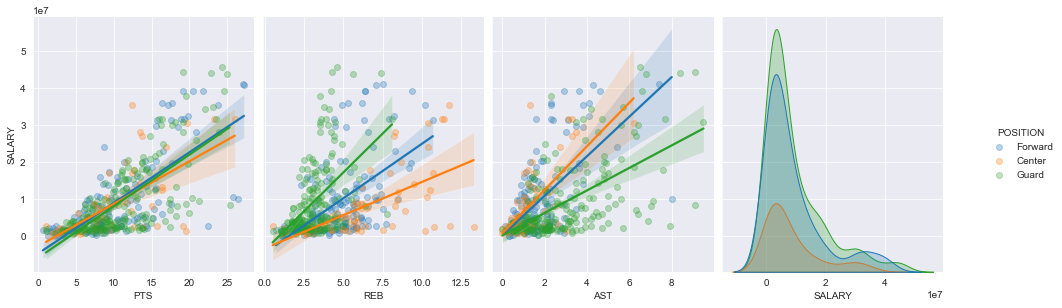

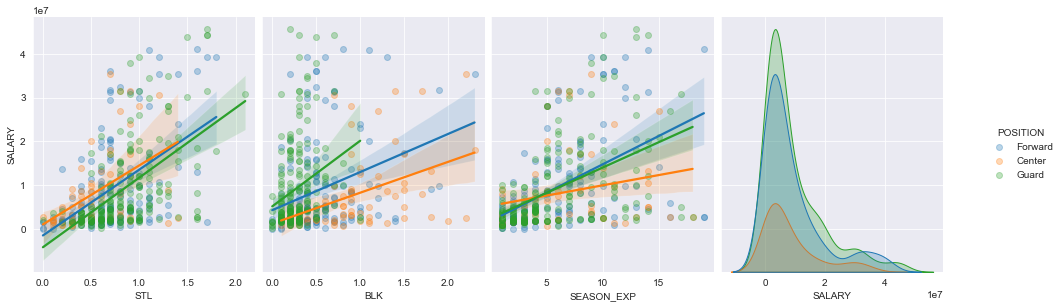

In [5]:
## Relationship between independent features (statistics) and target variable (Salary)

%matplotlib inline
sns.set_style('darkgrid')
p1 = sns.pairplot( data_stats, y_vars = ['SALARY'], x_vars = ["PTS", "REB", "AST", 'SALARY'], kind = 'reg', hue = 'POSITION', plot_kws = {'scatter_kws': {'alpha': 0.3}})
p2 = sns.pairplot( data_stats, y_vars = ['SALARY'], x_vars = ["STL","BLK","SEASON_EXP", 'SALARY'], kind = 'reg',hue = 'POSITION', plot_kws = {'scatter_kws': {'alpha': 0.3}})

p1.fig.set_size_inches(15,5)
p2.fig.set_size_inches(15,5)
plt.show()

data_stats.drop(columns=['POSITION'],inplace = True)

We are only interested in the last column: SALARY vs others


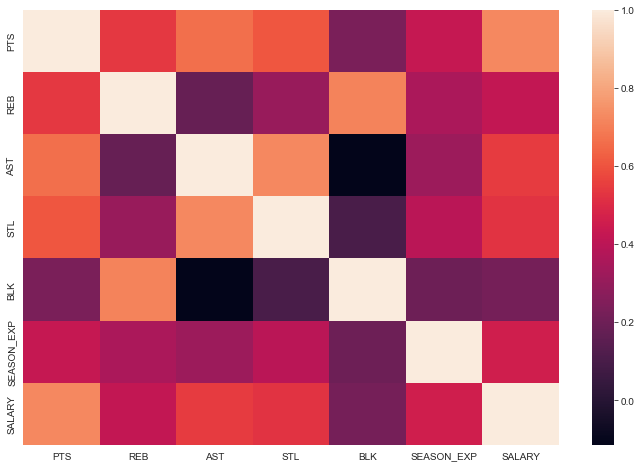

In [6]:
h1, ax1 = plt.subplots(1,1,figsize=(12,8))
_ = sns.heatmap(data = data_stats[stats_cols + ['SALARY']].corr(), ax = ax1)
print('We are only interested in the last column: SALARY vs others')

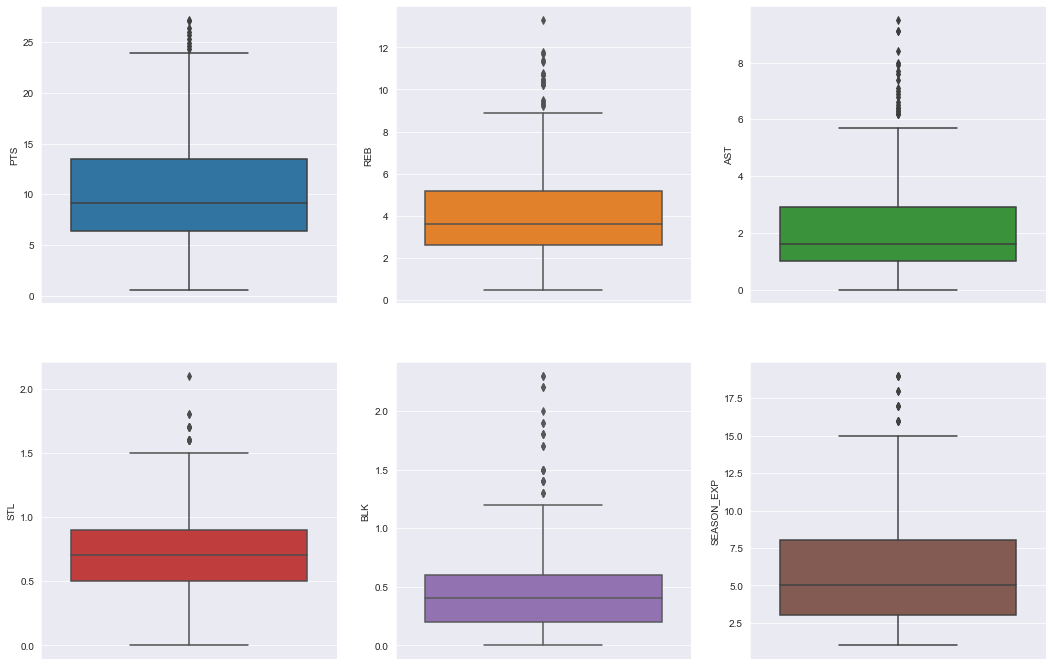

In [7]:
colors = get_cmap('tab10').colors

fig, ax = plt.subplots(2,3, figsize = (18,12))


for k,col in enumerate(data_stats.columns[:-1]):
    i, j = divmod(k, 3)
    sns.boxplot(data = data_stats, y = data_stats[col], ax = ax[i,j], color = colors[k])


In [8]:
outliers_perc = {}
for stat in stats_cols:

    iqr = np.quantile(data_stats[stat],.75) - np.quantile(data_stats[stat],.25)
    uppper_bound = np.quantile(data_stats[stat],.75) + 1.5*iqr
    
    outliers_perc[stat] = str(f'{(sum(data_stats[stat] > uppper_bound)/len(data_stats[stat])*100):.2f}%')
    
print(f'Percent(%) of outliers per feature:\n{outliers_perc}')

Percent(%) of outliers per feature:
{'PTS': '2.10%', 'REB': '4.20%', 'AST': '5.13%', 'STL': '4.43%', 'BLK': '6.06%', 'SEASON_EXP': '2.80%'}


**There are outliers in the data. However, there are two main reason why we won't drop them:**

> _1. The % of outliers per features is too low._

> _2. The outliers in the NBA case has a good explanation: outlier values correspond to outperformers i.e. highly skilled NBA players (stars) in the league, which is exactly what where are trying to estimate for in this project ._

1.2. What can we say about these distributions?

> **ANSWER**
> + _All of the statistics have a positive correlation (some strong,other not so much) with the SALARY._ 
> + _All of the distributions are right-skewed_.
> + There are some outliers (which we will ignore).

> _On the boxplot, we can observe that there are a lot of some outliers in each feature. I don't think it is a good idea to drop them nor fit them to the distribution, as they most probably represent skilled players on the NBA, which usually have outstanding performance (i.e. statistics)_


### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

**Note:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

In [9]:
# TODO: Put here your features
X_single = data.drop(columns = 'SALARY')
# TODO: Put here your labels
y_single = data.SALARY

# TODO: Now use train_test_split()
X_train_single, X_test_single,y_train_single, y_test_single = train_test_split(X_single,y_single, train_size = 0.8, random_state = 42)

*Don't change anything in this cell, just make it run correctly*

In [10]:
if X_single.SEASON_EXP[322] == 7 and y_single[255] == 1517981:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

if X_single.shape == (429, 18) and y_single.shape == (429,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!
Success!


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [11]:
class BaselineModel():
    """
    A baseline model that always returns the same value, the mean of the 
    players salary in the train data
    """
    def __init__(self):
        self.mean = None

    def fit(self, y_train):
        """
        Fit the training data. 

        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        """
        self.mean = y_train.mean()


    def predict(self, X):
        """
        Predict salaries 

        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the 

        Returns
        -------
        np.ndarray
            a numpy array of the same length as X, with all elements equal to 
            the mean salary calculated in fit()
        """
        return np.array([self.mean]*len(X))

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [12]:
bl = BaselineModel()
bl.fit(y_train_single)
y_pred_bl = bl.predict(X_test_single)

print(f'MAE: {int(MAE(y_test_single,y_pred_bl))}')

MAE: 6815073


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [13]:
X_train_single = X_train_single.PTS.values.reshape(-1,1)
X_test_single =  X_test_single.PTS.values.reshape(-1,1)

rob_scaler_single = RobustScaler()
X_train_single_scaled = rob_scaler_single.fit_transform(X_train_single)
X_test_single_scaled = rob_scaler_single.transform(X_test_single)

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [14]:
sgd = SGDRegressor()

sgd.fit(X_train_single_scaled, y_train_single)

y_pred_single = sgd.predict(X_test_single_scaled)

print(f'Single MAE: {int(MAE(y_test_single,y_pred_single))}')

Single MAE: 4527246


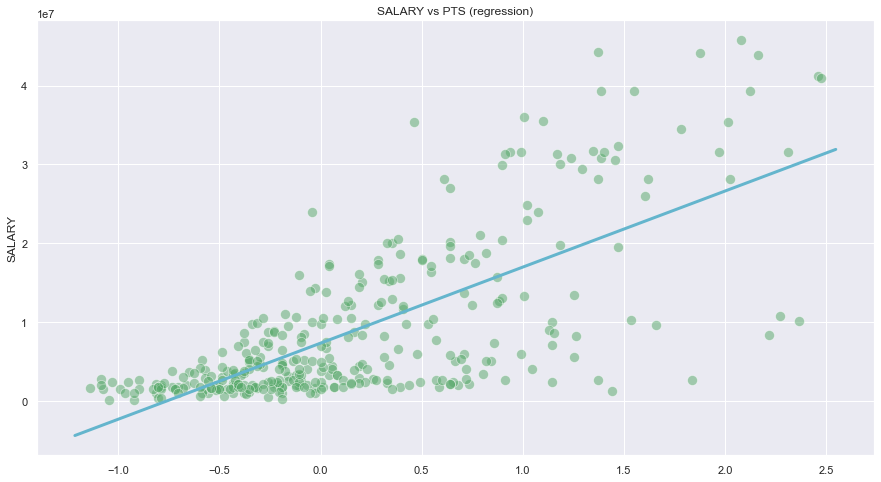

In [15]:
weights = [sgd.intercept_,sgd.coef_]
def plot_regressor(xx,yy,weights):
    # Plotting data points
    sns.set(rc = {'figure.figsize':(15,8)})
    _ = sns.scatterplot(x = xx.ravel(),y = yy, color = 'g', alpha = .5, s = 100)

    # We'll plot the regression line along
    b = weights[0]
    m = weights[1:]
    r = 0.02*(max(xx) - min(xx))
    xx = np.linspace(min(xx-r),max(xx + r),100)
    yy = m*xx + b
    _ = plt.plot(xx,yy, color = 'c', linewidth = 3)
    _ = plt.title('SALARY vs PTS (regression)')

plot_regressor(X_train_single_scaled,y_train_single,weights)

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [73]:
def search_best_hyperparameters(splitted_data,estimator,params_grid,scoring):
       
    p_values = params_grid.values()
    all_params_comb = list(itertools.product(*p_values))

    best_estimator = None
    best_params = {}
    if scoring.__name__ ==  'mean_absolute_error': best_metric = max(data_stats.SALARY)
    elif scoring.__name__ ==  'f1_score':  best_metric = 0

    xx_train, xx_test,yy_train,yy_test = splitted_data
    
    for params_comb in all_params_comb:
        
        param_dict = {k:v for k,v in zip(params_grid.keys(),params_comb)}

        model = estimator(**param_dict)
        model.fit(xx_train,yy_train)
        yy_pred = model.predict(xx_test)
        
        metric = scoring(yy_test,yy_pred)
        
        if (scoring.__name__ ==  'mean_absolute_error' and metric < best_metric)  \
        or ( scoring.__name__ ==  'f1_score' and metric > best_metric):
            
            best_metric = metric
            best_params = param_dict
            best_estimator = model
       
    return best_estimator,best_params,best_metric

In [74]:
# Performace of best single regressor
## Hyperparameters
alpha = [10**(-k) for k in np.arange(1,6, dtype = float)]                 # [0.1,...,0.00001] 
max_iter = [10**(k) for k in np.arange(4,6,0.5,dtype = float)]            # [10000,...,~3162277] 
eta0 = alpha[:-1]                                                         # [0.1,...,0.0001] 

params_dict = {'alpha': alpha, 'max_iter':max_iter, 'eta0': eta0}

## Regressor model
sgd = SGDRegressor
data_single = (X_train_single,X_test_single,y_train_single,y_test_single) 

best_sgd_single, best_params_single, best_mae_single = search_best_hyperparameters(data_single,sgd,params_dict,MAE)
print(f'Params: {best_params_single}\nBest MAE: {best_mae_single:.0f}')

Params: {'alpha': 0.0001, 'max_iter': 316227.7660168379, 'eta0': 0.01}
Best MAE: 4524194


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [75]:
baseline_mae = int(MAE(y_test_single,y_pred_bl))
single_mae = int(MAE(y_test_single,y_pred_single))

print("Mean Absolute Error for each model:")
print(f"> Baseline: {baseline_mae}")
print(f"> Default SGDRegressor: {single_mae}")
print(f"> Best SGDRegressor: {best_mae_single:.0f}")

Mean Absolute Error for each model:
> Baseline: 6815073
> Default SGDRegressor: 4527246
> Best SGDRegressor: 4524194


### Multivariable Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [19]:
# TODO: Complete here
mv_regression_df = data[["PERSON_ID","PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]].copy(deep = True)
mv_regression_df.set_index('PERSON_ID',inplace=True)

*Don't change anything in this cell, just make it run correctly*

In [20]:
if mv_regression_df.shape == (429, 8):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted,[np.NaN]: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [21]:
bins = [1,15,30,60, np.inf]
cat_names = ['firstround_lottery', 'firstround_non_lottery', 'second_round', 'undrafted']


# New DRAFT columns and pre-processing
mv_regression_df['DRAFT'] = mv_regression_df.DRAFT_NUMBER.replace(['Undrafted', np.NaN], '1000')
mv_regression_df.DRAFT= mv_regression_df.DRAFT.astype('uint16')

# Cut into bins
mv_regression_df.DRAFT = pd.cut(mv_regression_df.DRAFT, bins, labels = cat_names)

# Drop DRAFT_NUMBER
mv_regression_df = mv_regression_df.drop( columns = ['DRAFT_NUMBER'])

# Rearrange columns (SALARY at last)
cols_mv = mv_regression_df.columns.tolist()
cols_mv = cols_mv[:-2] + [cols_mv[-1]] + [cols_mv[-2]]

mv_regression_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,SALARY,DRAFT
PERSON_ID,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,Forward,2711280,firstround_non_lottery
203500,9.3,8.0,1.5,0.9,9,Center,17073171,firstround_lottery
1628389,13.5,8.3,3.5,0.9,5,Center,28103550,firstround_lottery
1630583,4.1,2.7,0.7,0.3,1,Forward,1994520,firstround_non_lottery
200746,19.1,8.1,1.9,1.1,16,Center,2641691,firstround_lottery
...,...,...,...,...,...,...,...,...
1626153,7.2,3.2,3.0,0.4,7,Guard,8526316,firstround_non_lottery
201152,12.8,5.8,1.8,0.4,15,Forward,14190000,firstround_lottery
1629027,25.3,3.9,9.1,0.2,4,Guard,8326471,firstround_lottery


*Don't change anything in this cell, just make it run correctly*

In [22]:
if mv_regression_df["DRAFT"].iloc[34] == 'firstround_lottery' and mv_regression_df["DRAFT"].iloc[105] == 'second_round':
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.12. Encode the categorical features: DRAFT, POSITION

In [23]:
mv_regression_df_encoded = pd.get_dummies(mv_regression_df, columns= ['DRAFT', 'POSITION'])

*Don't change anything in this cell, just make it run correctly*

In [24]:
if mv_regression_df_encoded["DRAFT_firstround_non_lottery"].iloc[134] == 1 and mv_regression_df_encoded["POSITION_Forward"].iloc[205] == 0:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')
mv_regression_df_encoded.head()

Success!


,PTS,REB,AST,BLK,SEASON_EXP,SALARY,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,POSITION_Forward,POSITION_Guard
PERSON_ID,,,,,,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,2711280,0,1,0,0,0,1,0
203500,9.3,8.0,1.5,0.9,9,17073171,1,0,0,0,1,0,0
1628389,13.5,8.3,3.5,0.9,5,28103550,1,0,0,0,1,0,0
1630583,4.1,2.7,0.7,0.3,1,1994520,0,1,0,0,0,1,0
200746,19.1,8.1,1.9,1.1,16,2641691,1,0,0,0,1,0,0


#### Modeling

1.13. Split the dataset into train and test. 


**Note 1:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

**Note 2:** Remember to drop `DRAFT_NUMBER` column if you haven't done that before

In [25]:
# TODO: Put here your features
X_mult = mv_regression_df_encoded.drop(columns= ['SALARY'])
# TODO: Put here your labels
y_mult = mv_regression_df_encoded.SALARY

# TODO: Now use train_test_split()
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(X_mult,y_mult, train_size = 0.8, random_state = 42)

*Don't change anything in this cell, just make it run correctly*

In [26]:
if X_mult.BLK.iloc[353] == 0.1 and y_mult.iloc[400] == 8729020:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [27]:
# Scaling data
rob_scaler_mult = RobustScaler()
X_train_mult_scaled = rob_scaler_mult.fit_transform(X_train_mult)
X_test_mult_scaled = rob_scaler_mult.transform(X_test_mult)

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [28]:
def SGD_multi_reg(splitted_data,params_dict):
    
    ## Regressor model
    sgd = SGDRegressor

    return search_best_hyperparameters(splitted_data,sgd,params_dict,MAE)
    

In [29]:
# We will reutilize parameter set for SingleSGDRegressor
params_dict = {'alpha': alpha, 'max_iter':max_iter, 'eta0': eta0}

data_mult = (X_train_mult_scaled,X_test_mult_scaled,y_train_mult,y_test_mult) 

beat_sgd_mult,best_params_mult, best_mae_mult= SGD_multi_reg(data_mult,params_dict)
print(f'Params: {best_params_mult}\nBest MAE: {best_mae_mult:.0f}')

Params: {'alpha': 0.0001, 'max_iter': 316227.7660168379, 'eta0': 0.1}
Best MAE: 4114918


1.16. How did the model performed compared to our univariate models? 

In [30]:
print(f"Best single SGDRegressor: {best_mae_single:.0f}")
print(f"Best MULTI SGDRegressor: {best_mae_mult:.0f}")

Best single SGDRegressor: 4576212
Best MULTI SGDRegressor: 4114918


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [31]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [32]:
def TreeRegressor(splitted_data,param_dict):
    # Estimator
    dtree = DecisionTreeRegressor
 
    return search_best_hyperparameters(splitted_data,dtree,param_dict,MAE)
    

In [33]:
# Hyperparameters to tune
param_dict = {    'max_depth': max_depth, 
                  'min_samples_leaf': min_samples_leaf,
                  'max_features': max_features  }

# Data 
data_tree = data_mult

# Getting MAE
best_tree_model,best_tree_params,best_mae_tree = TreeRegressor(data_tree,param_dict)

In [34]:
print(f"Best single SGDRegressor: {best_mae_single:.0f}")
print(f"Best MULTI SGDRegressor: {best_mae_mult:.0f}")
print(f"Best Tree Regressor: {best_mae_tree:.0f}")

Best single SGDRegressor: 4576212
Best MULTI SGDRegressor: 4114918
Best Tree Regressor: 3166155


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

**Best Regressor: _>> DecissionTreeClassifier - NON-Linear <<_**

>Why? Because the DecissionTreeClassifier is more flexible in the way in fits the data, since it can capture non-linear properties in the data better. This can be seen in the graphic below:


The plot is not linear like the one before


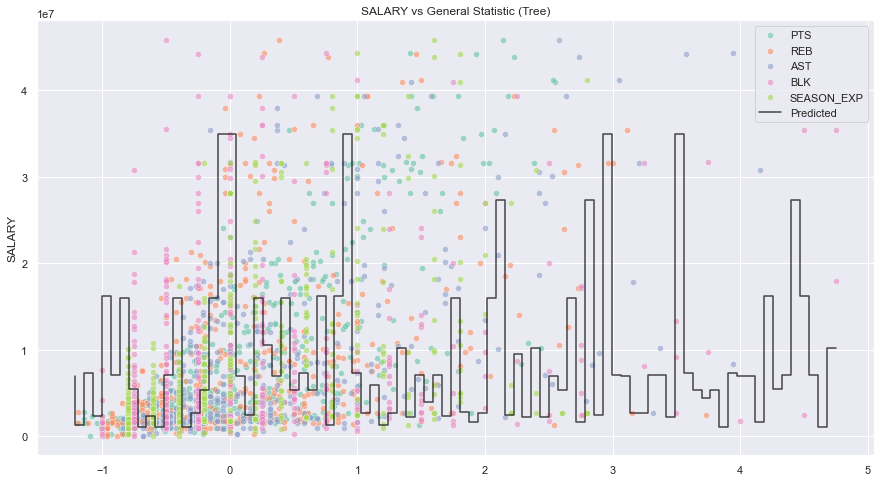

In [35]:
colors = get_cmap('Set2').colors
rob_scaler_tree = RobustScaler()
## Ploting the points
for col,c in zip(X_mult.loc[:,'PTS':'SEASON_EXP'],colors):
    xx = rob_scaler_tree.fit_transform(X_mult[col].values.reshape(-1,1)).ravel()
    _ = sns.scatterplot(x = xx,y = y_mult, color = c  , label= str(X_mult[col].name), alpha = .6)

# We'll plot the regression line along
y_pred_tree = best_tree_model.predict(X_test_mult_scaled)
xx = np.linspace(np.min(X_train_mult_scaled),np.max(X_train_mult_scaled),len(y_pred_tree))
fig = plt.step(xx,y_pred_tree, color = 'k', label = 'Predicted', alpha = .8)
_ = plt.title('SALARY vs General Statistic (Tree)')

_ = plt.legend()

print('The plot is not linear like the one before')

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

> **_ANSWER:_** 
* _We could implement other more sophisticated ML algorithms like RandomForestClassifier along with Adaptative or Gradient boosting, which are all Tree-Based models with different architectures and that gives better results overall_
* We could include the dummy features (one-hot encoded) that we created before

## 2. Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1983 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1983_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [36]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)
all_nba_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,15348,2817,2,Paul Zipser,2017-18,2017,CHI,54,12,15.3,...,0.355,0.760,2.4,0.9,0.4,0.3,0.8,1.6,4.0,0
14821,15349,2818,1,Ante Zizic,2017-18,2017,CLE,32,2,6.7,...,0.731,0.724,1.9,0.2,0.1,0.4,0.3,0.9,3.7,0
14822,15351,2819,1,Jim Zoet,1982-83,1982,DET,7,0,4.3,...,0.200,0.000,1.1,0.1,0.1,0.4,0.6,1.3,0.3,0
14823,15352,2820,1,Ivica Zubac,2016-17,2016,LAL,38,11,16.0,...,0.536,0.653,4.2,0.8,0.4,0.9,0.8,1.7,7.5,0


In [37]:
print(f'Number of records: {len(all_nba_df)}')
print(f'Number of seasons: {len(all_nba_df.season.unique())}')
print(f'Number of players(unique): {len(all_nba_df.player.unique())}')
print(f'Number of all-nba players selected: ({len(all_nba_df[all_nba_df.all_nba == 1])}) vs non-selected: ({len(all_nba_df[all_nba_df.all_nba == 0])}) ')


Number of records: 14825
Number of seasons: 39
Number of players(unique): 2701
Number of all-nba players selected: (496) vs non-selected: (14329) 


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [38]:
feat_cols = [ 'team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
target_col = ['all_nba'] 
# TODO: Put here your features
X_class = all_nba_df[feat_cols].values
# TODO: Put here your labels
y_class = all_nba_df[target_col].values.reshape(-1,)

# TODO: Now use train_test_split()
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class,y_class, train_size = .8, random_state = 42)

*Don't change anything in this cell, just make it run correctly*

In [39]:
if X_class.shape == (14825, 15) and y_class.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')

Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [40]:
def predict_zero():
    
    train_zeros = np.zeros(y_train_class.shape)
    test_zeros = np.zeros(y_test_class.shape)
    
    return accuracy_score(train_zeros, y_train_class),accuracy_score(test_zeros, y_test_class)

train_acc, test_acc = predict_zero()

print(f'Accuracy (train,test): ({train_acc:.3f},{test_acc:.3f})')  

Accuracy (train,test): (0.966,0.971)


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

> **ANSWER**: Even if there is no  ML model fitted/trained, the baseline model will ALWAYS predict a 0, with a very high accuracy ==> This is clearly not a good model, so accuracy is not an adequate metric.
This is observed due to class imbalance

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [41]:
feat_cols =  ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
target_col = ['all_nba'] 

X_log = all_nba_df[feat_cols] 
y_log = all_nba_df[target_col].values.ravel()

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log,y_log, train_size = .8, random_state = 42)

rob_scaler_log = RobustScaler()
X_train_log_scaled = rob_scaler_log.fit_transform(X_train_log)
X_test_log_scaled = rob_scaler_log.transform(X_test_log)

data_log_scaled = (X_train_log_scaled,X_test_log_scaled,y_train_log,y_test_log)

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [42]:
def logreg_baseline(data):

    xx_train, _ ,yy_train, _ = data
    logreg = LogisticRegression()
    
    logreg.fit(xx_train, yy_train)
    
    return logreg


## Adittional functions:
def get_metrics(estimator,data):
    
    _, xx_test, _ ,yy_test = data
    
    y_pred = estimator.predict(xx_test)
    
    return  accuracy_score(yy_test,y_pred), precision_score(yy_test,y_pred), \
            recall_score(yy_test,y_pred), f1_score(yy_test,y_pred) 

def display_confusion_matrix(estimator,data):
    
    _, xx_test, _ ,yy_test = data
    
    y_pred = estimator.predict(xx_test)
    
    cm = confusion_matrix(y_pred,yy_test)
    disp = ConfusionMatrixDisplay(cm, display_labels=estimator.classes_)

    disp.plot()
    plt.show()

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [43]:
logreg_bs = logreg_baseline(data_log_scaled)
acc_b, prec_b,rec_b, f1_b = get_metrics(logreg_bs,data_log_scaled)

print(f'Accuracy: {acc_b:.3f}')
print(f'Precision: {prec_b:.3f}')
print(f'Recall: {rec_b:.3f}')
print(f'F1-score: {f1_b:.3f}')

Accuracy: 0.984
Precision: 0.836
Recall: 0.586
F1-score: 0.689


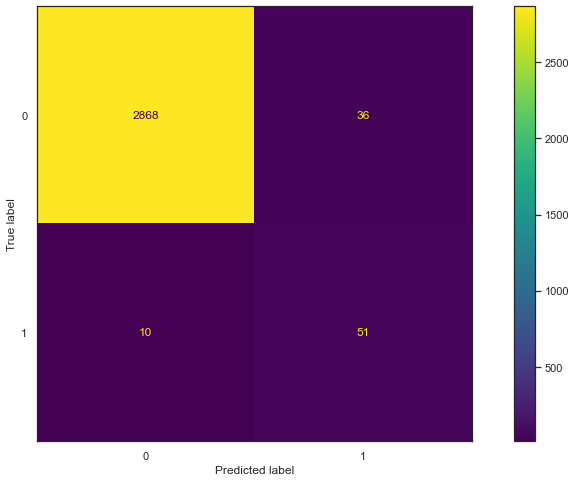

In [44]:
sns.set_style('white')
display_confusion_matrix(logreg_bs,data_log_scaled)
sns.set_style('darkgrid')

From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [45]:
# One-hot encoding
all_nba_df_encoded = pd.get_dummies(all_nba_df, columns= ['team'], drop_first= True)

# Columns: features vs target 
feat_cols = list(all_nba_df_encoded.loc[:,'games':])
if 'all_nba' in feat_cols:  feat_cols.remove('all_nba') 
target_col = ['all_nba']

# Data preparation
X_onehot = all_nba_df_encoded[feat_cols]
y_onehot = all_nba_df_encoded[target_col].values.ravel()

# Train-test split
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X_onehot,y_onehot, train_size = .8, random_state = 42)

rob_scale_onehot = RobustScaler()
X_train_onehot_scaled = rob_scale_onehot.fit_transform(X_train_onehot)
X_test_onehot_scaled = rob_scale_onehot.transform(X_test_onehot)

data_onehot = (X_train_onehot_scaled, X_test_onehot_scaled, y_train_onehot, y_test_onehot)

all_nba_df_encoded

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,team_SAC,team_SAS,team_SDC,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
0,0,0,1,Alaa Abdelnaby,1990-91,1990,43,0,6.7,0.474,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,71,1,13.2,0.493,...,0,0,0,0,0,0,0,0,0,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,75,52,17.5,0.518,...,0,0,0,0,0,1,0,0,0,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,13,0,12.2,0.436,...,0,0,0,0,0,0,0,0,0,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,54,0,9.4,0.511,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,15348,2817,2,Paul Zipser,2017-18,2017,54,12,15.3,0.346,...,0,0,0,0,0,0,0,0,0,0
14821,15349,2818,1,Ante Zizic,2017-18,2017,32,2,6.7,0.731,...,0,0,0,0,0,0,0,0,0,0
14822,15351,2819,1,Jim Zoet,1982-83,1982,7,0,4.3,0.200,...,0,0,0,0,0,0,0,0,0,0
14823,15352,2820,1,Ivica Zubac,2016-17,2016,38,11,16.0,0.529,...,0,0,0,0,0,0,0,0,0,0


**>> Using non-hot-encoded columns works better for logistic regression**

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [46]:
def find_logreg_best(splitted_data,param_dict):
    
    # Estimator model 
    logreg = LogisticRegression
    
    return search_best_hyperparameters(splitted_data,logreg,param_dict,f1_score)

In [47]:
# Hyperparameter
C = [0.5,1,2,5,10]
max_iter = [1000,2000,2500,5000]
tols= [10**(-k) for k in range(2,6)]     # [0.01,...,0.00001]

params_log = {'C':C,'max_iter':max_iter, 'tol':tols}

logreg_best_estimator,logreg_best_params,logreg_best_mae= find_logreg_best(data_onehot,params_log)

In [48]:
acc_log, prec_log,rec_log, f1_log =  get_metrics(logreg_best_estimator,data_onehot)
      
print(f'Accuracy: {acc_log:.3f}  ...(vs baseline: {acc_b:.3f})')
print(f'Precision: {prec_log:.3f}  ...(vs baseline: {prec_b:.3f})')
print(f'Recall: {rec_log:.3f}  ...(vs baseline: {rec_b:.3f})')
print(f'F1-score: {f1_log:.3f}  ...(vs baseline: {f1_b:.3f})')

Accuracy: 0.987  ...(vs baseline: 0.984)
Precision: 0.912  ...(vs baseline: 0.836)
Recall: 0.598  ...(vs baseline: 0.586)
F1-score: 0.722  ...(vs baseline: 0.689)


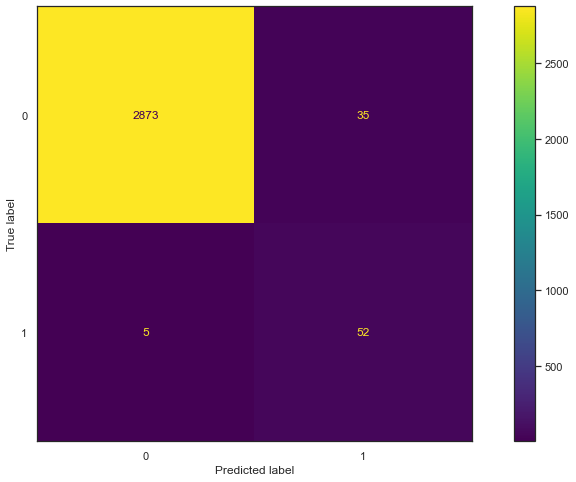

In [49]:
## Confusion matrix
sns.set_style('white')
display_confusion_matrix(logreg_best_estimator,data_onehot)
sns.set_style('darkgrid')

#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [50]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [51]:
## One-hot encoding
all_nba_2018_df_encoded = pd.get_dummies(all_nba_2018_df, columns = ['team'], drop_first = True )
all_nba_2018_df_encoded.columns

Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE', 'team_DAL',
       'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND', 'team_LAC',
       'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA', 'team_WAS'],
      dtype='object')

In [52]:
## Getting team columns to add
team_cols_to_add = list(set(all_nba_df_encoded.columns).difference(set(all_nba_2018_df_encoded.columns)))
team_cols_to_add.remove('all_nba')
print('Columns to add:')
team_cols_to_add

Columns to add:


['team_CHH',
 'team_CHA',
 'team_WSB',
 'team_KCK',
 'team_VAN',
 'team_NOK',
 'team_SDC',
 'team_NJN',
 'team_NOH',
 'team_SEA']

In [53]:
# Preserving only numerical features
all_nba_2018_df_encoded = all_nba_2018_df_encoded.loc[:,'games':].copy()
## Adding team columns
all_nba_2018_df_encoded[team_cols_to_add] = 0

*Don't change anything in this cell, just make it run correctly*

In [54]:
if all_nba_2018_df_encoded.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')
all_nba_2018_df_encoded



Success!


,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,team_CHH,team_CHA,team_WSB,team_KCK,team_VAN,team_NOK,team_SDC,team_NJN,team_NOH,team_SEA
34,31,2,19.0,0.357,0.323,0.500,0.923,1.5,0.6,0.5,...,0,0,0,0,0,0,0,0,0,0
49,10,0,12.3,0.222,0.133,0.667,0.700,2.5,0.8,0.1,...,0,0,0,0,0,0,0,0,0,0
70,34,1,12.6,0.345,0.338,0.361,0.778,1.8,1.9,0.4,...,0,0,0,0,0,0,0,0,0,0
71,80,80,33.4,0.595,0.000,0.596,0.500,9.5,1.6,1.5,...,0,0,0,0,0,0,0,0,0,0
79,82,28,23.3,0.576,0.200,0.588,0.735,7.3,2.2,0.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,81,81,30.9,0.418,0.324,0.477,0.829,3.7,8.1,0.9,...,0,0,0,0,0,0,0,0,0,0
15333,49,47,25.4,0.551,0.273,0.570,0.787,6.8,2.1,0.8,...,0,0,0,0,0,0,0,0,0,0
15334,6,1,15.5,0.533,0.000,0.552,0.778,4.0,0.7,0.2,...,0,0,0,0,0,0,0,0,0,0
15350,59,25,18.3,0.553,0.000,0.553,0.705,5.4,0.9,0.2,...,0,0,0,0,0,0,0,0,0,0


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [55]:
rob_scaler_val = RobustScaler()
X_test_val = rob_scaler_val.fit_transform(all_nba_2018_df_encoded) 
y_test_val = all_nba_2018_selections.all_nba.ravel()
data_val = (None,X_test_val,None,y_test_val)

acc_val, prec_val, rec_val,f1_val = get_metrics(logreg_best_estimator,data_val)

print(f'Accuracy: {acc_val:.3f}')
print(f'Precision: {prec_val:.3f}')
print(f'Recall: {rec_val:.3f}')
print(f'F1-score: {f1_val:.3f}')


Accuracy: 0.981
Precision: 0.600
Recall: 1.000
F1-score: 0.750


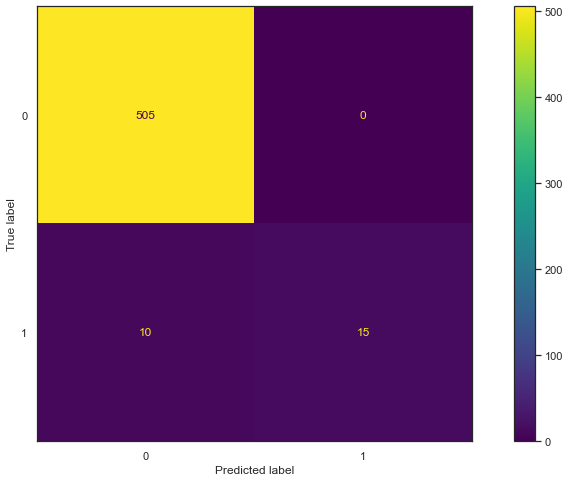

In [56]:
## Confusion matrix
sns.set_style('white')
display_confusion_matrix(logreg_best_estimator,data_val)
sns.set_style('darkgrid')

2.12. Analyze the results, what do you think it is happening?

* _The estimator is working well in general, when predicting outcomes on new (unseen) data. Good indicators of this are the recall and f1-score, which are slightly better than the training, metrics. However, precision has decreased._
* _There can be some fluctuations in the metrics (excluding accuracy) because the classes are highly imbalanced. In the confusion matrix plotted we can observe that the majority class is 0 (i.e. not select as an all-nba star), so accuracy is really high because of the true positives._
* _Precision and recall (and thus f1-score) bounce below and above in a acceptable interval. This is because the relative proportions between false positives, false negatives and true negatives change a little bit around the minority class. They tend to fluctuate a little more against the metrics that involve the majority class (i.e. true negatives)_

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [57]:
nba_player_probs = all_nba_2018_df.copy(deep = True).loc[:,:'pts']
nba_player_probs['prob_all_nba'] = logreg_best_estimator.predict_proba(X_test_val)[:,1].round(3)
nba_player_probs

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,prob_all_nba
34,34,5,2,Alex Abrines,2018-19,2018,OKC,31,2,19.0,...,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3,0.000
49,49,8,7,Quincy Acy,2018-19,2018,PHO,10,0,12.3,...,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7,0.000
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,34,1,12.6,...,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2,0.000
71,71,13,6,Steven Adams,2018-19,2018,OKC,80,80,33.4,...,0.596,0.500,9.5,1.6,1.5,1.0,1.7,2.6,13.9,0.018
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,82,28,23.3,...,0.588,0.735,7.3,2.2,0.9,0.8,1.5,2.5,8.9,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,15319,2806,1,Trae Young,2018-19,2018,ATL,81,81,30.9,...,0.477,0.829,3.7,8.1,0.9,0.2,3.8,1.7,19.1,0.239
15333,15326,2808,6,Cody Zeller,2018-19,2018,CHO,49,47,25.4,...,0.570,0.787,6.8,2.1,0.8,0.8,1.3,3.3,10.1,0.000
15334,15334,2810,7,Tyler Zeller,2018-19,2018,TOT,6,1,15.5,...,0.552,0.778,4.0,0.7,0.2,0.5,0.7,3.3,7.7,0.000
15350,15350,2818,2,Ante Zizic,2018-19,2018,CLE,59,25,18.3,...,0.553,0.705,5.4,0.9,0.2,0.4,1.0,1.9,7.8,0.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [58]:
nba_player_probs.nlargest(n = 15, columns=['prob_all_nba'])[['player_id','player','prob_all_nba']]

,player_id,player,prob_all_nba
453,83,Giannis Antetokounmpo,1.000
5604,1024,James Harden,1.000
6857,1240,LeBron James,0.999
3401,587,Anthony Davis,0.998
4145,740,Joel Embiid,0.988
14027,2572,Nikola Vucevic,0.979
14479,2648,Russell Westbrook,0.969
13673,2501,Karl-Anthony Towns,0.959
8103,1492,Kawhi Leonard,0.946
7225,1315,Nikola Jokic,0.943


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [59]:
player_selected_2018  = all_nba_2018_selections[all_nba_2018_selections.all_nba == 1].player
print('>Actually selected<\n',player_selected_2018)

>Actually selected<
 453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object


In [60]:
player_pred_2018 = all_nba_2018_selections[all_nba_2018_selections.all_nba == 1].player
print('>Prediction selected<\n',player_pred_2018)

>Prediction selected<
 453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object


In [61]:
print('Players predicted that were not selected: ', list(set(player_pred_2018).difference(player_selected_2018)))

Players predicted that were not selected:  []


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [62]:
class AllNbaSingleSeasonClassifier():
    
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self._model = model
      
  def predict(self, X):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    X: pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    X = X.copy()
    xx_test = rob_scaler_val.fit_transform(X) 
    X['probs'] = self._model.predict_proba(xx_test)[:,1].round(3)
    return X.nlargest(n = 15,  columns = ['probs'])['probs']

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [63]:
custom_cls = AllNbaSingleSeasonClassifier(logreg_best_estimator)
custom_cls.predict(all_nba_2018_df_encoded)

453      1.000
5604     1.000
6857     0.999
3401     0.998
4145     0.988
14027    0.979
14479    0.969
13673    0.959
8103     0.946
7225     0.943
3908     0.914
14132    0.910
5016     0.887
4895     0.877
6634     0.828
Name: probs, dtype: float64

#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

> _The main problem is that the classes in the dataset are imbalaced, so our model will be "biased" towards the majority class_

2.19. What do you think we could do to improve our model?

> _We should try to correct for the imbalance, with a sampling technique._

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [64]:
# we need to update the packages to make sure we don't have versin conflicts
!pip install -U sklearn 
!pip install -U imbalanced-learn --user

In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
sm = SMOTE(random_state = 42)

# Oversampling
X_smote, y_smote = sm.fit_resample(X_onehot,y_onehot)
print(f'Lenght before sampling: {len(X_onehot)}')
print(f'Lenght after sampling: {len(X_smote)}')

print(f'\nZeros vs Non Zeros (before sampling): {(len(y_onehot) - y_onehot.sum())/len(y_onehot):.3f} vs {y_onehot.sum()/len(y_onehot):.3f}')
print(f'Zeros vs Non Zeros (after sampling): {(len(y_smote) - y_smote.sum())/len(y_smote):.3f} vs {y_smote.sum()/len(y_smote):.3f}')
# logreg_best_estimator,logreg_best_params,logreg_best_mae = find_logreg_best(data_onehot,params)

Lenght before sampling: 14825
Lenght after sampling: 28658

Zeros vs Non Zeros (before sampling): 0.967 vs 0.033
Zeros vs Non Zeros (after sampling): 0.500 vs 0.500


In [67]:
# Train-Test split
X_train_smote,X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote,y_smote, train_size=.9, random_state=42)

#Feature scaling
rob_scaler_smote = RobustScaler()
X_train_smote_scaled = rob_scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = rob_scaler_smote.fit_transform(X_test_smote)

data_smote_scaled = X_train_smote_scaled,X_test_smote_scaled, y_train_smote, y_test_smote



In [68]:
# Train and test model (Logistic Regressor)
best_smote_logreg, best_smote_params, best_smote_mae = find_logreg_best(data_smote_scaled,params_log)

Accuracy: 0.980   ...(vs Non-Smote: 0.987)
Precision: 0.979   ...(vs Non-Smote: 0.912)
Recall: 0.981   ...(vs Non-Smote: 0.598)
F1-score: 0.980   ...(vs Non-Smote: 0.722)


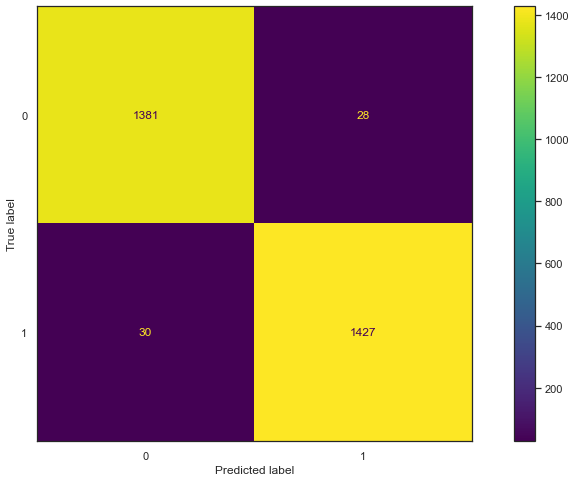

In [69]:
acc_smote,prec_smote,rec_smote,f1_smote = get_metrics(best_smote_logreg, data_smote_scaled)

print(f'Accuracy: {acc_smote:.3f}   ...(vs Non-Smote: {acc_log:.3f})')
print(f'Precision: {prec_smote:.3f}   ...(vs Non-Smote: {prec_log:.3f})')
print(f'Recall: {rec_smote:.3f}   ...(vs Non-Smote: {rec_log:.3f})')
print(f'F1-score: {f1_smote:.3f}   ...(vs Non-Smote: {f1_log:.3f})')

## Confusion matrix
sns.set_style('white')
display_confusion_matrix(best_smote_logreg,data_smote_scaled)
sns.set_style('darkgrid')

## 3. Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [70]:
  
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""

    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor

        Parameters
        ----------
        epochs: int
          number of epochs to run gradient descent
        learning_rate: float
          rate of update of the gradients
        """
        self.epochs = epochs
        self.learning_rate = learning_rate
        


    def _gradient_descent(self,X,y):
        """
        Gradient descent algorithm
        """
        # Dimesions
        m = X.shape[0]                                        # 429
        d = X.shape[1]                                        # 1
        
        # Update w:= w - alpha*grad    
        y_pred = X @ self.weights
        grad = 2/m * X.T@(y_pred - y)
        self.weights = self.weights - self.learning_rate * np.sum(grad,axis = 1).reshape(d,1)


    def fit(self, X, y):
        """
        Fit the model according to the given training data.

        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
                
        # Initializations
        m = X.shape[0]                                        # 429 .. datapoints
        X = np.concatenate([np.ones((m,1)),X], axis = 1)      # Adding a 1's column to take w0 into account
        d = X.shape[1]                                        # 2 since [w0,w1]
                
        self.weights = np.random.rand(d,1)                    # [w0,w1,w2,...w(m)](j)
        y = y.values.reshape(-1,1)

        for _ in range(self.epochs):
            self._gradient_descent(X,y)
       
    def predict(self, X):
        """
        Predict

        Parameters
        ----------
        X: np.ndarray

        Returns
        -------
        np.ndarray
          array with predictions
        """
        
        return X @ self.weights[:1] + self.weights[0]

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

Best params: {'learning_rate': 0.0001, 'epochs': 3400}
Weights: [w0,w1]=[4230930. 3645741.]


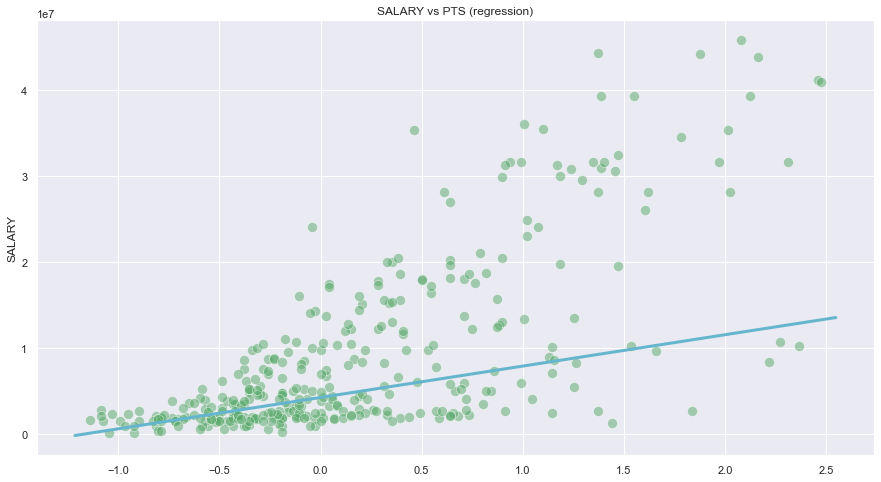

In [71]:
## --> we'll use the same data as before
data_linear = X_train_single_scaled,X_test_single_scaled,y_train_single,y_test_single
# Linear Regressor
hyperparams = {'learning_rate': [10**(-k) for k in range(4,10)], 'epochs':[100*i for i in range(10,35)]}

lr = LinearRegressor
best_lr,best_lr_params, best_lr_mae = search_best_hyperparameters(data_linear,lr,hyperparams,MAE)

print(f'Best params: {best_lr_params}')
print(f'Weights: [w0,w1]={np.round(best_lr.weights.ravel())}')


plot_regressor(data_linear[0],data_linear[2],best_lr.weights.ravel())

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.

In [72]:
 print(f'>> MAE(LinearRegressor): {best_lr_mae:.0f}    ... (vs SGD: {best_mae_single:.0f})')

>> MAE(LinearRegressor): 5249739    ... (vs SGD: 4576212)
